# Antwerp NWP runs
Some explaination and documentation about the NWP runs for the Antwerp case study. 

In [5]:
# Import necessary libraries

import os
import wget
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

from versions import UrbanAirData

warnings.filterwarnings("ignore")

g = 9.81

In [9]:
# Remote location of data for this version
# Directory of the runs
version = "4"
url = UrbanAirData().url_version(version)

datadir = f"data/{version}/"
if not os.path.isdir(datadir):
    os.makedirs(datadir)


# Leadtime
step = 1

atmo_file = f"GRIBPFDEOD+00{step:02d}h00m00s"
tile_file = f"GRIBTILEDEOD+00{step:02d}h00m00s.sfx"
const_file = "Const.Clim.grib2"
files = ["README.md", const_file, atmo_file, tile_file]
for filename in files:
    target = f"{datadir}/{filename}"
    if not os.path.isfile(target):
        file_url = f"{url}/{filename}"
        print(f"Downloading: {file_url}")
        wget.download(file_url, datadir)
    else:
        print(f"File already exists: {target}")

File already exists: data/4//README.md
File already exists: data/4//Const.Clim.grib2
File already exists: data/4//GRIBPFDEOD+0001h00m00s
File already exists: data/4//GRIBTILEDEOD+0001h00m00s.sfx


In [10]:
### create a function to make pretty maps

import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.ticker as mticker


def setup_map_subplots(ix, iy):
    """
    Setup default Cartopy map
    """
    # Map projection
    proj = ccrs.LambertConformal(central_longitude=4.9, central_latitude=51.967)
    # Create single axes object in Lambert projection
    fig, axs = plt.subplots(ix, iy, subplot_kw={"projection": proj})

    axs = axs.flatten()

    # Loop over all of the models
    for i, bla in enumerate(axs):

        # Draw coast lines, resolution = {'10m','50m','110m'}
        axs[i].coastlines(resolution="10m", linewidth=0.8, color="black")
        # Load country geometries and lakes (for the IJselmeer)
        # from www.naturalearthdata.com and add to axes
        countries = cfeature.NaturalEarthFeature(
            category="cultural",
            name="admin_0_boundary_lines_land",
            scale="10m",
            facecolor="none",
        )
        axs[i].add_feature(countries, edgecolor="black", linewidth=0.8)
        lakes = cfeature.NaturalEarthFeature(
            category="physical", name="lakes", scale="10m", facecolor="none"
        )
        axs[i].add_feature(lakes, edgecolor="black", linewidth=0.8)

    return fig, axs

## Domain properties
The domain looks like this at the moment. 

```
    dx = 500 m 
    dy = 500 m 
    ni = 139
    nj = 139 
    lat_centre = 51.25
    lon_centre = 4.05
```
The data provided do not include the background land use, but for reference here are some plots to show the nature, water and urban fractions in the domain. 

## Constant files 
The `Const.Clim.grib2` files contain the land-sea mask an the height of the orography. They can be read and plotted as follows.

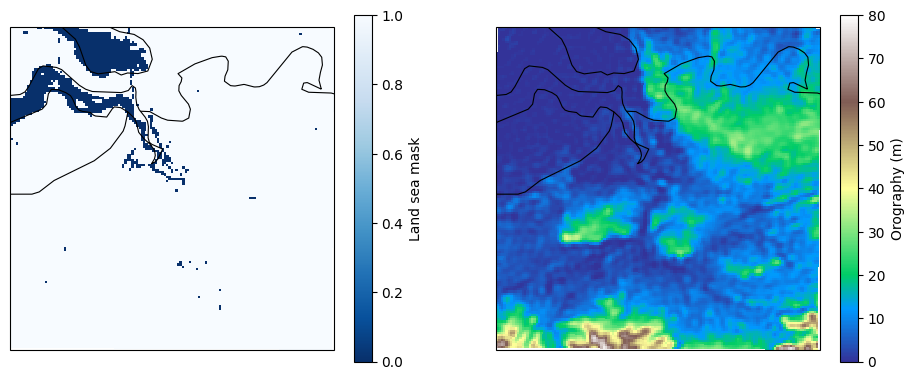

In [11]:
file_name = datadir + const_file

lsm = xr.open_dataset(
    file_name, engine="cfgrib", backend_kwargs={"filter_by_keys": {"shortName": "lsm"}}
)
h = xr.open_dataset(
    file_name, engine="cfgrib", backend_kwargs={"filter_by_keys": {"shortName": "h"}}
)
lsm

fig, ax = setup_map_subplots(1, 2)
fig.set_size_inches(11.5, 4.5)
im = ax[0].pcolormesh(
    lsm.longitude,
    lsm.latitude,
    lsm.lsm,
    cmap="Blues_r",
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=1,
)
fig.colorbar(im, ax=ax[0], label="Land sea mask")
im = ax[1].pcolormesh(
    h.longitude,
    h.latitude,
    h.h,
    cmap="terrain",
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=80,
)
fig.colorbar(im, ax=ax[1], label="Orography (m)")

# Soil and soil moisture
AROME/HARMONIE-AROME uses surface model SURFEX. For these runs a diffusion scheme is used for the soil.

The soil scheme consists of 14 layers, 0.01, 0.04, 0.10, 0.20, 0.40, 0.60, 0.80, 1.0, 1.5, 2.0, 3.0, 4.0, 8.0, 12.0 meter.
In these simulations, we only use three tiles (bare soil, low vegetation, and high vegetation). 

![](https://www.umr-cnrm.fr/IMG/png/fig1-2.png)

The soil data provided is either on the whole nature tile, or on each of the patches.
The soil files are called `GRIBTILEDEODE+HHHHhMMmSSs.sfx`, and can be read as indicated below. 

In the `filter_by_keys` function you can select which tile you want the soil data to selected, where `GNATU` is the aggregated over all the three nature tiles, `GNOVE` is the bare soil tile, `GTREE` is the high vegetation tile, `GLVEG` is the low vegetation tile. 

In [12]:
file_name = datadir + tile_file

soil = xr.open_dataset(
    file_name, engine="cfgrib", backend_kwargs={"filter_by_keys": {"tile": "GNATU"}}
)
soil

<xarray.Dataset> Size: 3MB
Dimensions:     (soilLayer: 14, y: 139, x: 139)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
  * soilLayer   (soilLayer) float64 112B 1.0 2.0 3.0 4.0 ... 11.0 12.0 13.0 14.0
    latitude    (y, x) float64 155kB ...
    longitude   (y, x) float64 155kB ...
    valid_time  datetime64[ns] 8B ...
    surface     float64 8B ...
Dimensions without coordinates: y, x
Data variables:
    liqvsm      (soilLayer, y, x) float32 1MB ...
    sot         (soilLayer, y, x) float32 1MB ...
    lai         (y, x) float32 77kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    history:                 2025-05-26T12:35 GRIB to CDM+CF via cfgrib-0.9.1...

Here the soil moisture is `liqvsm` and soil temperature is `sot` and are a function of each of the 14 soil layers and `x` and `y`.

Here is an example of the soil temperature and moisture at different points in the domain. 

Text(0, 0.5, 'Soil depth (m)')

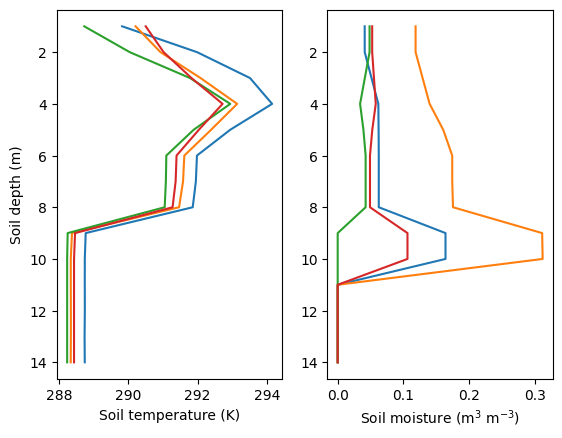

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(soil.sot[::-1, 70, 70], soil.soilLayer[::-1])
ax1.plot(soil.sot[::-1, 30, 30], soil.soilLayer[::-1])
ax1.plot(soil.sot[::-1, 100, 100], soil.soilLayer[::-1])
ax1.plot(soil.sot[::-1, 100, 70], soil.soilLayer[::-1])
ax1.invert_yaxis()
ax2.invert_yaxis()
ax2.plot(soil.liqvsm[::-1, 70, 70], soil.soilLayer[::-1])
ax2.plot(soil.liqvsm[::-1, 30, 30], soil.soilLayer[::-1])
ax2.plot(soil.liqvsm[::-1, 100, 100], soil.soilLayer[::-1])
ax2.plot(soil.liqvsm[::-1, 100, 70], soil.soilLayer[::-1])
ax1.set_xlabel("Soil temperature (K)")
ax2.set_xlabel(r"Soil moisture (m$^{3}$ m$^{-3}$)")
ax1.set_ylabel("Soil depth (m)")

## Atmospheric fields
For the atmospheric files (`GRIBPFDEOD+HHHHhMMmSSs`) several fields are provided. Check the `GRIBPFDEOD+0024h00m00s.toc` for all fields stored.

In order to read in the fields stored on model levels (hybrid), you can select the `typeOfLevel` to be `hybrid`. 

There is a bug in cfgrib where it doesn't have the right projection and therefore cannot read the 2 d data. Therefore we have to reshape the variables to the domain.

In [14]:
file_name = datadir + atmo_file
atm = xr.open_dataset(
    file_name,
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "hybrid"}},
)
atm

dims = (len(atm.hybrid), 139, 139)
lon = np.reshape(np.array(atm.longitude), dims[1:])
lat = np.reshape(np.array(atm.latitude), dims[1:])
t = np.zeros(dims)
q = np.zeros(dims)
z = np.zeros(dims)
w = np.zeros(dims)
for i in np.arange(dims[0]):
    t[i, :] = np.reshape(np.array(atm.t[i, :]), dims[1:])
    q[i, :] = np.reshape(np.array(atm.q[i, :]), dims[1:])
    z[i, :] = np.reshape(np.array(atm.z[i, :]), dims[1:]) / g  # convert to height
    w[i, :] = np.reshape(np.array(atm.wz[i, :]), dims[1:])

Text(0, 0.5, 'Altitude (m)')

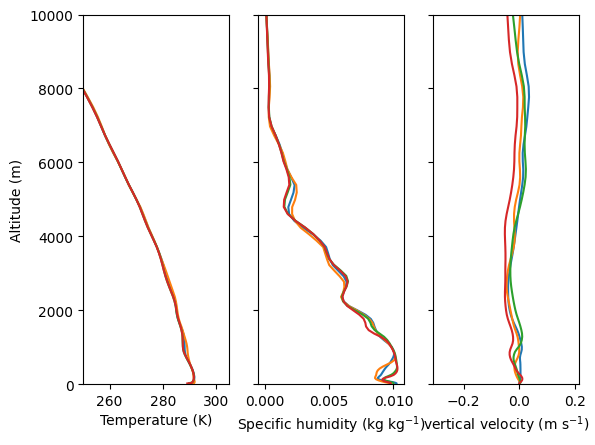

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.plot(t[::-1, 70, 70], z[::-1, 70, 70])
ax1.plot(t[::-1, 30, 30], z[::-1, 30, 30])
ax1.plot(t[::-1, 100, 100], z[::-1, 100, 100])
ax1.plot(t[::-1, 100, 70], z[::-1, 100, 70])
ax2.plot(q[::-1, 70, 70], z[::-1, 70, 70])
ax2.plot(q[::-1, 30, 30], z[::-1, 30, 30])
ax2.plot(q[::-1, 100, 100], z[::-1, 100, 100])
ax2.plot(q[::-1, 100, 70], z[::-1, 100, 70])
ax3.plot(w[::-1, 70, 70], z[::-1, 70, 70])
ax3.plot(w[::-1, 30, 30], z[::-1, 30, 30])
ax3.plot(w[::-1, 100, 100], z[::-1, 100, 100])
ax3.plot(w[::-1, 100, 70], z[::-1, 100, 70])
ax1.set_ylim(0, 10000)
ax1.set_xlim(250, 305)
ax1.set_xlabel("Temperature (K)")
ax2.set_xlabel(r"Specific humidity (kg kg$^{-1}$)")
ax3.set_xlabel(r"vertical velocity (m s$^{-1}$)")
ax1.set_ylabel("Altitude (m)")